In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import cv2
import tarfile
from pathlib import Path
from tqdm import tqdm
import shutil
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers as tfl
from tensorflow.keras.layers import *
from tensorflow_addons.image import transform as H_transform
import matplotlib.pyplot as plt
import os, datetime

In [3]:
seed = 1

In [4]:
!pwd

/root/Internship-Valeo/Project


In [5]:
DATA_PATH = '/root/Internship-Valeo/Project/data'

In [6]:
from datasets import synthetic_dataset
from datasets.utils import pipeline
from datasets.utils.pipeline import parse_primitives
from datasets.utils import photometric_augmentation as photaug
from models.homographies import (sample_homography, compute_valid_mask,
                                            warp_points, filter_points, flat2mat, mat2flat)
from models.utils import box_nms

from models.utils import shared_encoder, detector_head, detector_loss, model_metrics, box_nms
from utils.tools import dict_update

In [7]:
# read keypoints
def _read_points(filename):
    return np.load(filename).astype(np.float32)

In [8]:
import yaml
with open('/root/Internship-Valeo/Project/configs/magic-point_repeatability.yaml', 'r') as stream:
    config = yaml.safe_load(stream)

In [9]:
default_config = {
        'dataset': 'hpatches',  # or 'coco'
        'alteration': 'all',  # 'all', 'i' for illumination or 'v' for viewpoint
        'cache_in_memory': False,
        'truncate': None,
        'preprocessing': {
            'resize': False
        }
    }

In [10]:
config1 = config
config = dict_update(default_config, config['data'])

In [11]:
default_model_config = {
            'data_format': 'channels_last',
            'kernel_reg': 0.,
            'grid_size': 8,
            'detection_threshold': 0.4,
            'homography_adaptation': {'num': 0},
            'nms': 0,
            'top_k': 0
    }

In [12]:
model_config = dict_update(default_model_config, config1['model'])

In [13]:
class DetectorLossLayer(Layer):
    def __init__(self, name='detector_loss_layer', trainable=False):
        super(DetectorLossLayer, self).__init__(name=name)
        self.loss_fn = detector_loss
        self.metrics_fn = model_metrics
    def call(self, inputs, targets=None, sample_weight=None):
        loss = self.loss_fn(inputs[0], inputs[1]['logits'], model_config = model_config, valid_mask = inputs[2])
        
        if model_config['nms']:
            prob = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), inputs[1]['prob'])
        pred = tf.cast(tf.greater_equal(prob, model_config['detection_threshold']), tf.float32)
        
        metrics = self.metrics_fn(inputs[0], pred, valid_mask = inputs[2])
#         self.add_loss(tf.math.reduce_mean(loss))
        self.add_loss(loss)
        self.add_metric(metrics['precision'], name = 'precision')
        self.add_metric(metrics['recall'], name = 'recall')
        return loss
    def compute_output_shape(self, input_shape):
        return [1]

def net(input_shape1, input_shape2, input_shape3):
    images_inputs = Input(shape = input_shape1, name = 'image')
    valid_masks_inputs = Input(shape = input_shape2, name = 'valid_mask')
    warped_points_inputs = Input(shape = input_shape3, name = 'keypoints')
    
    encoder = shared_encoder(shape = (240, 320, 1), model_config = model_config)
    encoder_output = encoder(images_inputs)
    
    detector = detector_head(shape= (30, 40, 128), model_config = model_config)
    output = detector(encoder_output)
        
    loss_layer = DetectorLossLayer()([warped_points_inputs, output, valid_masks_inputs])
    
    model = keras.models.Model(inputs = [images_inputs, valid_masks_inputs, warped_points_inputs] , 
                               outputs = [loss_layer])
    return model

In [14]:
model = net(input_shape1 = (240, 320, 1), input_shape2 = (240, 320), input_shape3 = (240, 320))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


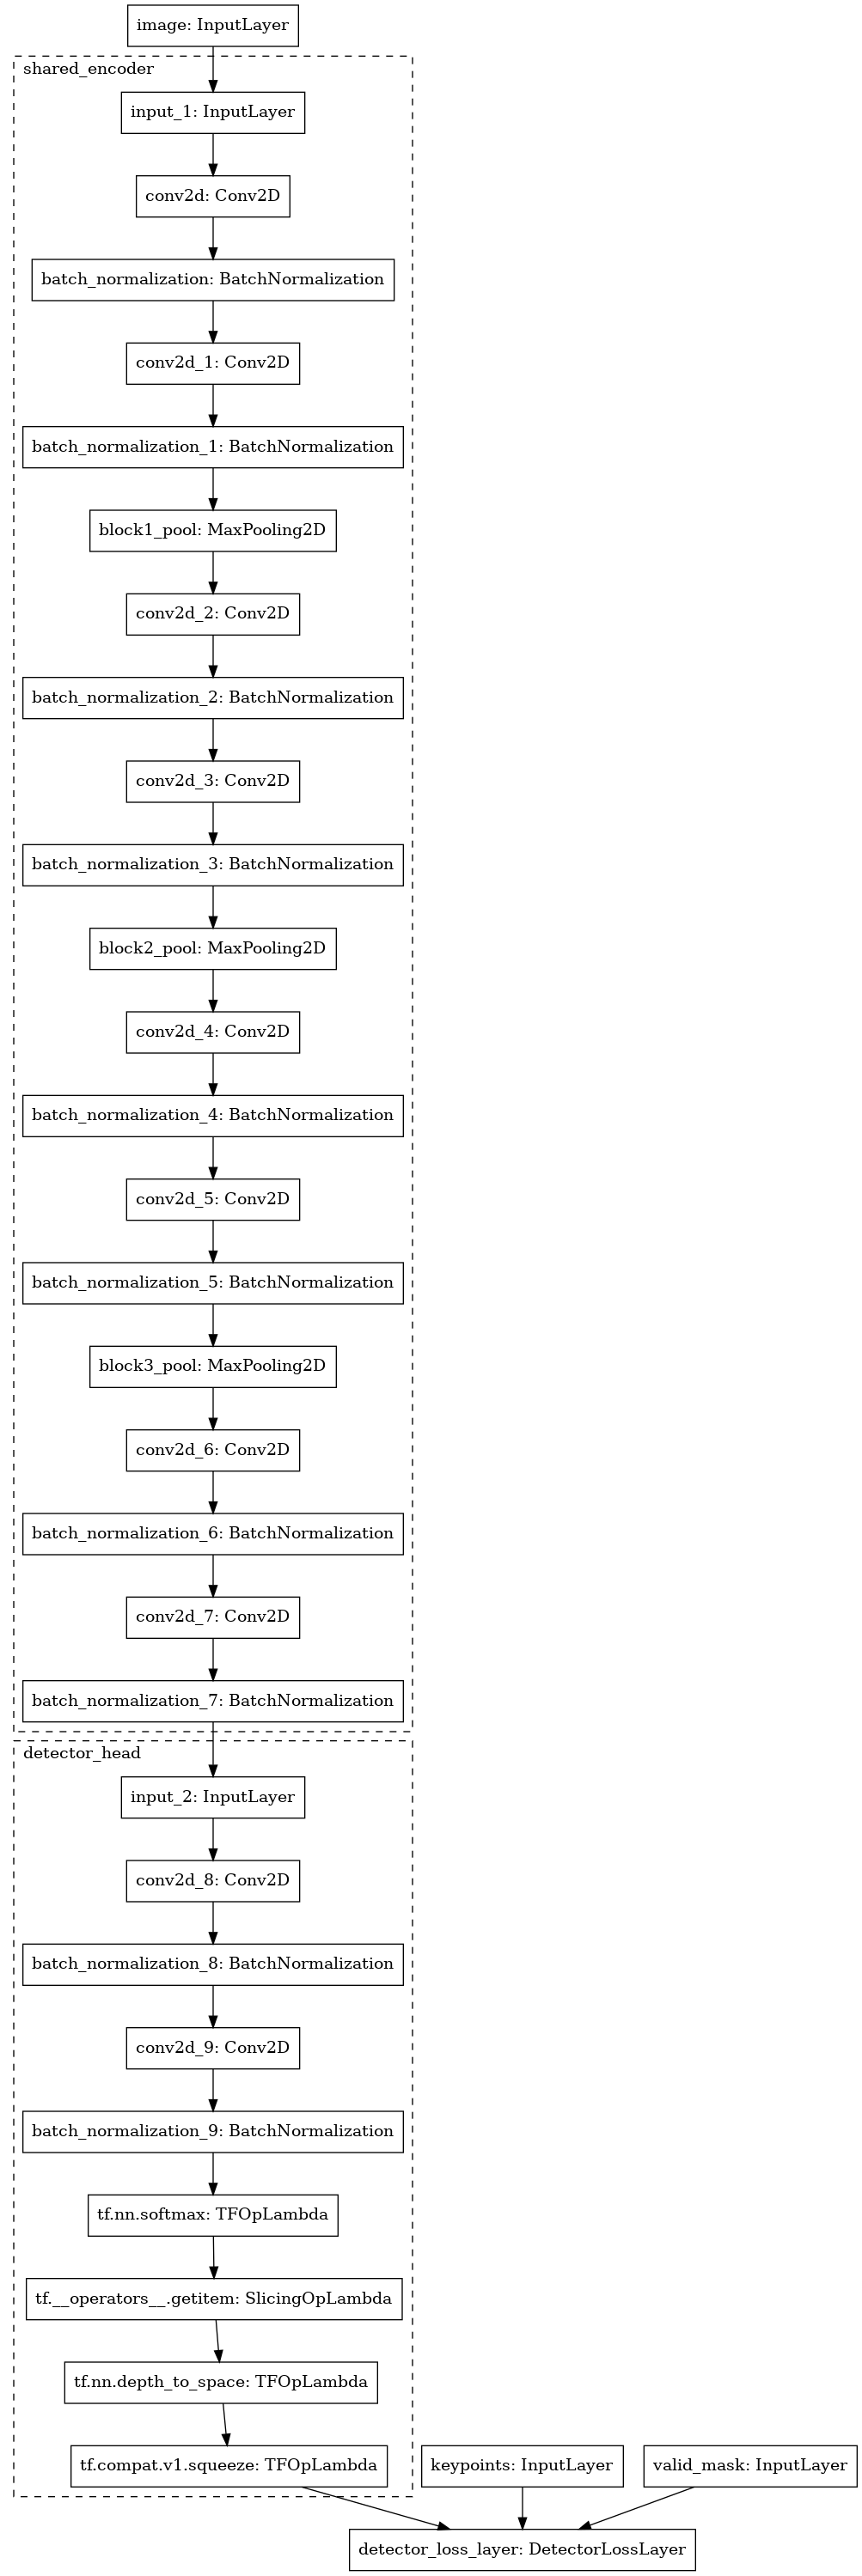

In [15]:
# model.summary()
keras.utils.plot_model(model, rankdir="TB", expand_nested=True)

In [16]:
# model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-coco-040422')
model.load_weights(filepath='/root/Internship-Valeo/Project/results/checkpoint-magicpoint-kitti360-240822')

In [17]:
# Make changes here for illumination vs viewpoint

# config = {
#     'data':{
#         'name': 'patches_dataset',
#         'dataset': 'hpatches',  # 'coco' 'hpatches'
#         'alteration': 'v',  # 'all' 'i' 'v'
#         'preprocessing':{'resize': [240, 320]},  # False for coco
#         'truncate': False,
#     },
#     'augmentation':{
#         'homographic':{
#             'valid_border_margin':3
#         },
#     },
#     'nms':4,
#     'top_k':1000,
#     'detection_threshold':.001,
# }

In [18]:
# Make changes here for illumination vs viewpoint

# output_dir = '/root/Internship-Valeo/Project/exports/superpoint_hpatches-i'
output_dir = '/root/Internship-Valeo/Project/exports/magic-point_kitti360_hpatches-repeatability-i'

In [19]:
config['alteration'] = 'i'

In [20]:
from datasets import patches_dataset
data = patches_dataset.PatchesDataset()
files = data._init_dataset(**config)
# train_gen = data._get_data(files, 'training', **config)
# train_gen = train_gen.batch(5)
val_gen = data._get_data(files, 'validation', **config)
# val_gen = val_gen.batch(5)

In [21]:
# dataset_folder = 'HPatches'
# base_path = Path(DATA_PATH, dataset_folder)
# folder_paths = [x for x in base_path.iterdir() if x.is_dir()]
# image_paths = []
# warped_image_paths = []
# homographies = []
# for path in folder_paths:
#     if config['data']['alteration'] == 'i' and path.stem[0] != 'i':
#         continue
#     if config['data']['alteration'] == 'v' and path.stem[0] != 'v':
#         continue
#     num_images = 1 if config['data']['dataset'] == 'coco' else 5
#     file_ext = '.ppm' if config['data']['dataset'] == 'hpatches' else '.jpg'
#     for i in range(2, 2 + num_images):
#         image_paths.append(str(Path(path, "1" + file_ext)))
#         warped_image_paths.append(str(Path(path, str(i) + file_ext)))
#         homographies.append(np.loadtxt(str(Path(path, "H_1_" + str(i)))))
# if config['data']['truncate']:
#     image_paths = image_paths[:config['truncate']]
#     warped_image_paths = warped_image_paths[:config['truncate']]
#     homographies = homographies[:config['truncate']]
# files = {'image_paths': image_paths,
#                  'warped_image_paths': warped_image_paths,
#                  'homography': homographies}

In [22]:
# def adapt_homography_to_preprocessing(homography, image_shape, warped_image_shape):
#     H = tf.cast(homography, tf.float32)
#     source_size = tf.cast(image_shape, tf.float32)
#     source_warped_size = tf.cast(warped_image_shape, tf.float32)
#     target_size = tf.cast(tf.convert_to_tensor(config['data']['preprocessing']['resize']),
#                                   tf.float32)

#     # Compute the scaling ratio due to the resizing for both images
#     s = tf.reduce_max(tf.divide(target_size, source_size))
#     up_scale = tf.linalg.diag(tf.stack([1. / s, 1. / s, tf.constant(1.)]))
#     warped_s = tf.reduce_max(tf.divide(target_size, source_warped_size))
#     down_scale = tf.linalg.diag(tf.stack([warped_s, warped_s, tf.constant(1.)]))

#     # Compute the translation due to the crop for both images
#     pad_y = tf.cast(((source_size[0] * s - target_size[0]) / tf.constant(2.0)), tf.int32)
#     pad_x = tf.cast(((source_size[1] * s - target_size[1]) / tf.constant(2.0)), tf.int32)
#     translation = tf.stack([tf.constant(1), tf.constant(0), pad_x, 
#                                     tf.constant(0), tf.constant(1), pad_y,
#                                     tf.constant(0),tf.constant(0), tf.constant(1)])
#     translation = tf.cast(tf.reshape(translation, [3,3]), tf.float32)
#     pad_y = tf.cast(((source_warped_size[0] * warped_s - target_size[0])
#                                  / tf.constant(2.0)), tf.int32)
#     pad_x = tf.cast(((source_warped_size[1] * warped_s - target_size[1])
#                                  / tf.constant(2.0)), tf.int32)
#     warped_translation = tf.stack([tf.constant(1), tf.constant(0), -pad_x, 
#                                            tf.constant(0), tf.constant(1), -pad_y,
#                                            tf.constant(0),tf.constant(0), tf.constant(1)])
#     warped_translation = tf.cast(tf.reshape(warped_translation, [3,3]), tf.float32)
#     H = warped_translation @ down_scale @ H @ up_scale @ translation
#     return H

In [23]:
# class DataGen(keras.utils.Sequence):
#     def __init__(self, image_path, warped_image_path, homography,                  
#                  image_size_x = 320, image_size_y = 240, batch_size = 2):
        
#         self.__image_path = image_path
#         self.__homography = homography
#         self.__warped_image_path = warped_image_path
#         self.__image_size_x = image_size_x
#         self.__image_size_y = image_size_y
#         self.__batch_size = batch_size
#         self.on_epoch_end()
        
#     def __getitem__(self, index):
#         images = []
#         homography_list = []
#         warped_images = []
#         valid_masks = []
        
#         if (index + 1)*self.__batch_size > len(self.__image_path):
#             self.__batch_size = len(self.__image_path) - index * self.__batch_size
            
#         batch_img_files = self.__image_path[index * self.__batch_size:(index + 1) * self.__batch_size]
#         batch_warped_img_files = self.__warped_image_path[
#             index * self.__batch_size:(index + 1) * self.__batch_size]
#         batch_homography = self.__homography[index * self.__batch_size:(index + 1) * self.__batch_size]
#         for img_file, warped_img_file, homography, itr in zip(
#             batch_img_files, batch_warped_img_files, batch_homography, range(self.__batch_size)):
            
#             image = cv2.imread(img_file, 0)
#             source_image_shape = image.shape
#             image = cv2.resize(image , (self.__image_size_x , self.__image_size_y))
#             image = np.expand_dims(image, axis = 2)
#             image_shape = tf.shape(image)[:2]    
#             # read warped image

#             warped_image = cv2.imread(warped_img_file, 0)
#             source_warped_image_shape = warped_image.shape
#             warped_image = cv2.resize(warped_image , (self.__image_size_x , self.__image_size_y))
#             warped_image = np.expand_dims(warped_image, axis = 2)
            
#             homography = adapt_homography_to_preprocessing(homography, source_image_shape, 
#                                                            source_warped_image_shape)
            
#             homography = mat2flat(homography)
#             homography = tf.squeeze(homography)
#             homography_list.append(homography)
#             # compute valid mask
#             valid_mask = compute_valid_mask(image_shape, homography,
#                                          config['augmentation']['homographic']['valid_border_margin'])
#             valid_masks.append(valid_mask)
#             warped_image = warped_image / 255.0
#             warped_images.append(warped_image) 
#             image = image / 255.0
#             images.append(image)   
              
#         images = np.array(images)
#         warped_images = np.array(warped_images)
#         homography_list = np.array(homography_list)
#         valid_masks = np.array(valid_masks)
#         return [images, homography_list, warped_images, valid_masks]

           
#     def __len__(self):
#         return int(np.ceil(len(self.__image_path) / float(self.__batch_size)))
    
#     def on_epoch_end(self):
#         pass

In [24]:
# image_path = files['image_paths']
# warped_image_path = files['warped_image_paths']
# homography = files['homography']
# test_set = DataGen(image_path, warped_image_path, homography, batch_size = 1)

In [25]:
# x = test_set.__getitem__(14)

In [26]:
# plt.imshow(x[2][0],cmap = 'gray')

In [27]:
# x[0].shape

In [28]:
# x[1].shape

In [29]:
# x[2].shape

In [30]:
# x[3].shape

In [31]:
# for i in range(len(files['image_paths'])):
#     filename = str(i)
#     filepath = Path(output_dir, '{}.npz'.format(filename))
    
#     x = test_set.__getitem__(i)
    
#     y_pred1 = m.predict(x[0])

#     if model_config['nms']:
#         prob1 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
#                                                min_prob=model_config['detection_threshold'],
#                                                keep_top_k=model_config['top_k']), y_pred1)
# #         pred1 = tf.cast(tf.greater_equal(prob1, model_config['detection_threshold']), tf.float32)
    

#     y_pred2 = m.predict(x[2])

#     if model_config['nms']:
#         prob2 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
#                                                min_prob=model_config['detection_threshold'],
#                                                keep_top_k=model_config['top_k']), y_pred2)
# #         pred2 = tf.cast(tf.greater_equal(prob2, model_config['detection_threshold']), tf.float32)
# #     prob2 = prob2*x[3]
#     homography = x[1]
#     homography = flat2mat(homography)
#     pred = {'image': x[0][0],
#             'warped_image': x[2][0],
#             'prob': prob1[0],
#             'warped_prob': prob2[0],
#             'homography': homography[0]}
    
    
#     np.savez_compressed(filepath, **pred)

In [32]:
# prob = model.get_layer('tf.compat.v1.squeeze').output

prob = model.get_layer('detector_loss_layer').input[1]['prob']
m = keras.models.Model(inputs = model.input[0], outputs = prob)

In [33]:
from tqdm import tqdm
val_gen = val_gen.batch(1)
x = iter(val_gen)

pbar = tqdm(total=config1['eval_iter'] if config1['eval_iter'] > 0 else None)
i = 0
while True:
    try:
        data = x.get_next()
    except data.end_set:
        break
    data1 = {'image': data['image'][0]}
    data2 = {'image': data['warped_image'][0]}
    y_pred1 = m.predict(data['image'])
    if model_config['nms']:
        prob1 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred1)
        
    y_pred2 = m.predict(data['warped_image'])
    if model_config['nms']:
        prob2 = tf.map_fn(lambda p: box_nms(p, model_config['nms'],
                                               min_prob=model_config['detection_threshold'],
                                               keep_top_k=model_config['top_k']), y_pred2)
    pred = {'image': data['image'][0], 
            'warped_image': data['warped_image'][0],
            'prob': prob1[0], 'warped_prob': prob2[0],
                    'homography': data['homography'][0]}

#     if not ('name' in data):
#         pred.update(data)
    filename = data['name'][0].decode('utf-8') if 'name' in data else str(i)
    filepath = Path(output_dir, '{}.npz'.format(filename))
    np.savez_compressed(filepath, **pred)
    i += 1
    pbar.update(1)
    if i == config1['eval_iter']:
        break

 28%|██▊       | 285/1000 [00:34<01:31,  7.83it/s]

AttributeError: 'dict' object has no attribute 'end_set'